# Wood Dataset Preprocessing Pipeline
Bu notebook, MVTec AD 'wood' sınıfına ait görsellerin denetimsiz anomali tespiti modelleri için ön işlenmesini içermektedir. Amaç; train/test ayrımı, arka plan temizleme, normalize etme ve boyutlandırma gibi işlemleri gerçekleştirmektir.


## Google Drive Bağlantısı ve Klasörlerin Hazırlanması
Bu bölümde Google Drive bağlanır ve işlenmiş görseller için `train/good`, `test/good`, `test/defect`, `ground_truth/defect` gibi klasörler oluşturulur.


In [ ]:
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import os

# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)


# Drive'dan veri setine erişim
data_path = '/content/drive/MyDrive/wood_dataset'

# İşlenmiş resimler için çıkış ana klasörü
processed_data_path = '/content/drive/MyDrive/processed_dataset'

# Gerekli dizinleri oluştur (train, test, ground_truth)
subdirs = ['train/good', 'test/good', 'test/defect', 'ground_truth/defect']
for subdir in subdirs:
    full_path = os.path.join(processed_data_path, 'wood', subdir)
    os.makedirs(full_path, exist_ok=True)

print("Tüm dizinler oluşturuldu ve hazır.")

Mounted at /content/drive
Tüm dizinler oluşturuldu ve hazır.


## Arka Plan Temizleme
Orijinal ahşap görsellerin arka planı, renk eşiği veya kenar çıkarım yöntemleri ile temizlenir. Böylece model sadece yüzey kusurlarına odaklanır.


In [ ]:
def crop_and_clean(image):
    # Gri tonlamaya çevir
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Otsu Threshold uygula
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Siyah olmayan alanları bul
    coords = cv2.findNonZero(thresh)

    if coords is not None:
        # En küçük dikdörtgeni belirle ve kırp
        x, y, w, h = cv2.boundingRect(coords)
        cropped_image = image[y:y+h, x:x+w]

        # İkinci kontrol
        gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        _, clean_thresh = cv2.threshold(gray_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Yeniden kırp
        new_coords = cv2.findNonZero(clean_thresh)
        if new_coords is not None:
            x2, y2, w2, h2 = cv2.boundingRect(new_coords)
            cropped_image = cropped_image[y2:y2+h2, x2:x2+w2]

    return cropped_image


## Görsel Normalize Etme ve 256x256 Boyutlandırma
Tüm görseller normalize edilerek 0-1 aralığına çekilir ve 256x256 boyutuna getirerek modele uygun hale getirilir.


In [ ]:
def resize_and_normalize(image, target_size=(256, 256)):
    # Boyutlandırma
    resized_image = cv2.resize(image, target_size)

    # Normalizasyon [0, 1] aralığına
    normalized_image = resized_image / 255.0

    return normalized_image


In [ ]:
def enhance_contrast_clahe(image):
    # Gri tonlamaya çevir
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE oluştur
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # CLAHE uygula
    equalized = clahe.apply(gray)

    # Tekrar 3 kanallıya çevir
    equalized_color = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

    return equalized_color


In [ ]:
def process_image(image):
    # Kırpma ve temizleme
    cropped_image = crop_and_clean(image)

    # Kontrast artırma
    # enhanced_image = enhance_contrast_clahe(cropped_image) sonra tekrar denenir

    # Boyutlandırma ve normalizasyon
    final_image = resize_and_normalize(cropped_image)


    return final_image


## Görsellerin Kayıt Aşamaları
Her bir görsel uygun klasöre `.png` formatında kaydedilir. Train set sadece `good`, test set ise `good` ve `defect` şeklinde ayrı ayrı ayrılır.


In [ ]:
# İşlenecek alt klasörler
subdirs_to_process = ['train/good', 'test/good', 'test/defect']

for subdir in subdirs_to_process:
    input_dir = os.path.join(data_path, 'wood', subdir)
    output_dir = os.path.join(processed_data_path, 'wood', subdir)
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('jpg', 'png')):
            img_path = os.path.join(input_dir, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Atlandı: {filename} okunamadı.")
                continue

            processed_image = process_image(image)
            processed_image = (processed_image * 255).astype(np.uint8)

            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

            print(f"{subdir}/{filename} işlendi ve kaydedildi.")

print("Tüm klasörlerdeki resimler işlendi ve processed_dataset klasörüne kaydedildi.")

train/good/11.jpg işlendi ve kaydedildi.
train/good/6.jpg işlendi ve kaydedildi.
train/good/4.jpg işlendi ve kaydedildi.
train/good/5.jpg işlendi ve kaydedildi.
train/good/9.jpg işlendi ve kaydedildi.
train/good/10.jpg işlendi ve kaydedildi.
train/good/7.jpg işlendi ve kaydedildi.
train/good/8.jpg işlendi ve kaydedildi.
train/good/12.jpg işlendi ve kaydedildi.
train/good/19.jpg işlendi ve kaydedildi.
train/good/24.jpg işlendi ve kaydedildi.
train/good/16.jpg işlendi ve kaydedildi.
train/good/20.jpg işlendi ve kaydedildi.
train/good/30.jpg işlendi ve kaydedildi.
train/good/29.jpg işlendi ve kaydedildi.
train/good/22.jpg işlendi ve kaydedildi.
train/good/23.jpg işlendi ve kaydedildi.
train/good/28.jpg işlendi ve kaydedildi.
train/good/21.jpg işlendi ve kaydedildi.
train/good/13.jpg işlendi ve kaydedildi.
train/good/26.jpg işlendi ve kaydedildi.
train/good/15.jpg işlendi ve kaydedildi.
train/good/31.jpg işlendi ve kaydedildi.
train/good/18.jpg işlendi ve kaydedildi.
train/good/34.jpg işle

In [ ]:
import cv2
import os

# Ground truth klasör yolları
src_gt = os.path.join(data_path, 'wood', 'ground_truth', 'defect')
dst_gt = os.path.join(processed_data_path, 'wood', 'ground_truth', 'defect')

# Çıkış klasörü varsa yok say, yoksa oluştur
os.makedirs(dst_gt, exist_ok=True)

# Maskeleri işle
for filename in os.listdir(src_gt):
    if filename.lower().endswith(('.png', '.jpg')):
        src_path = os.path.join(src_gt, filename)
        dst_path = os.path.join(dst_gt, filename)

        # Maskeyi gri tonlamada oku
        mask = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

        # Yeniden boyutlandır (normalize etmeden!)
        resized_mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Kaydet
        cv2.imwrite(dst_path, resized_mask)

print("Ground truth maskeleri 256x256 boyutuna getirilerek kaydedildi.")



Ground truth maskeleri 256x256 boyutuna getirilerek kaydedildi.


## Örnek İşlenmiş Görsellerin Gösterimi
Bu hücrede, işlenmiş verilerden örnek görseller gösterilir. Görsellerin işlenme başarısı bu adımda hızlıca doğrulanabilir.

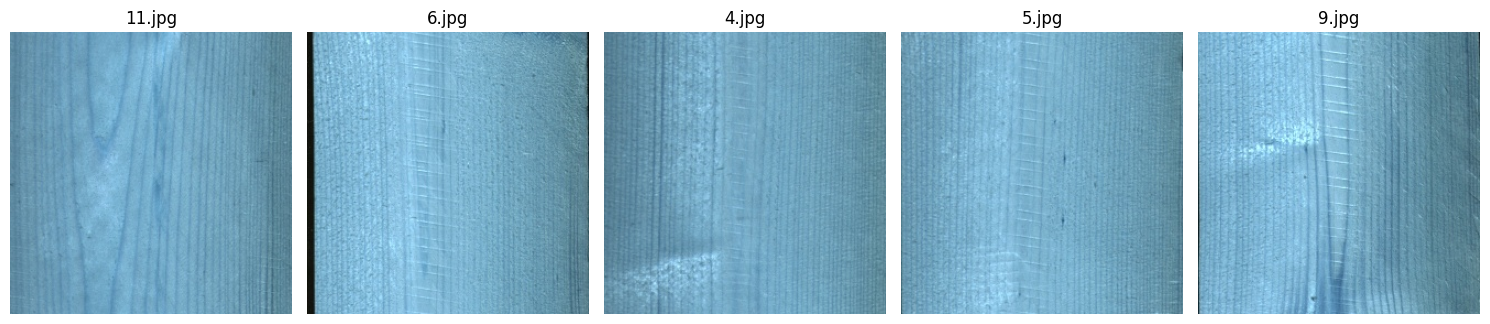

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2

# İşlenmiş train klasörü yolu
train_dir = os.path.join(processed_data_path, 'wood', 'train', 'good')

# İlk 5 işlenmiş görüntüyü al
sample_images = os.listdir(train_dir)[:5]
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for idx, filename in enumerate(sample_images):
    img_path = os.path.join(train_dir, filename)
    processed_image = cv2.imread(img_path)
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(processed_image)
    axes[idx].axis("off")
    axes[idx].set_title(f"{filename}")

plt.tight_layout()
plt.show()